### 理解模型


### 还是这些工具包

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

sns.set(font_scale = 2)

# Imputing missing values
from sklearn.preprocessing import Imputer, MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import tree

# LIME for explaining predictions
import lime 
import lime.lime_tabular

### 先拿到我们上个模型的结果

In [2]:
# Read in data into dataframes 
train_features = pd.read_csv('data/training_features.csv')
test_features = pd.read_csv('data/testing_features.csv')
train_labels = pd.read_csv('data/training_labels.csv')
test_labels = pd.read_csv('data/testing_labels.csv')

In [3]:
# Create an imputer object with a median filling strategy
imputer = Imputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

# Sklearn wants the labels as one-dimensional vectors
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

In [4]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [5]:
model = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

model.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=800, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [6]:
#  Make predictions on the test set
model_pred = model.predict(X_test)

print('Final Model Performance on the test set: MAE = %0.4f' % mae(y_test, model_pred))

Final Model Performance on the test set: MAE = 9.0837


### 解释我们的模型

* 特征重要性
* Locally Interpretable Model-agnostic Explainer (LIME)
* 建立一颗树模

### 特征重要性

[sklearn中特征重要性的计算方法](https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined)

在所有树模型中平均节点不纯度的减少

In [7]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(train_features.columns), 
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,Site EUI (kBtu/ft²),0.403532
1,Weather Normalized Site Electricity Intensity ...,0.263059
2,Water Intensity (All Water Sources) (gal/ft²),0.071286
3,Property Id,0.035165
4,Largest Property Use Type_Non-Refrigerated War...,0.031924
5,DOF Gross Floor Area,0.027900
6,log_Water Intensity (All Water Sources) (gal/ft²),0.026058
7,Order,0.024592
8,log_Direct GHG Emissions (Metric Tons CO2e),0.023655
9,Year Built,0.022100


差异还是蛮大的，画图来看更清楚

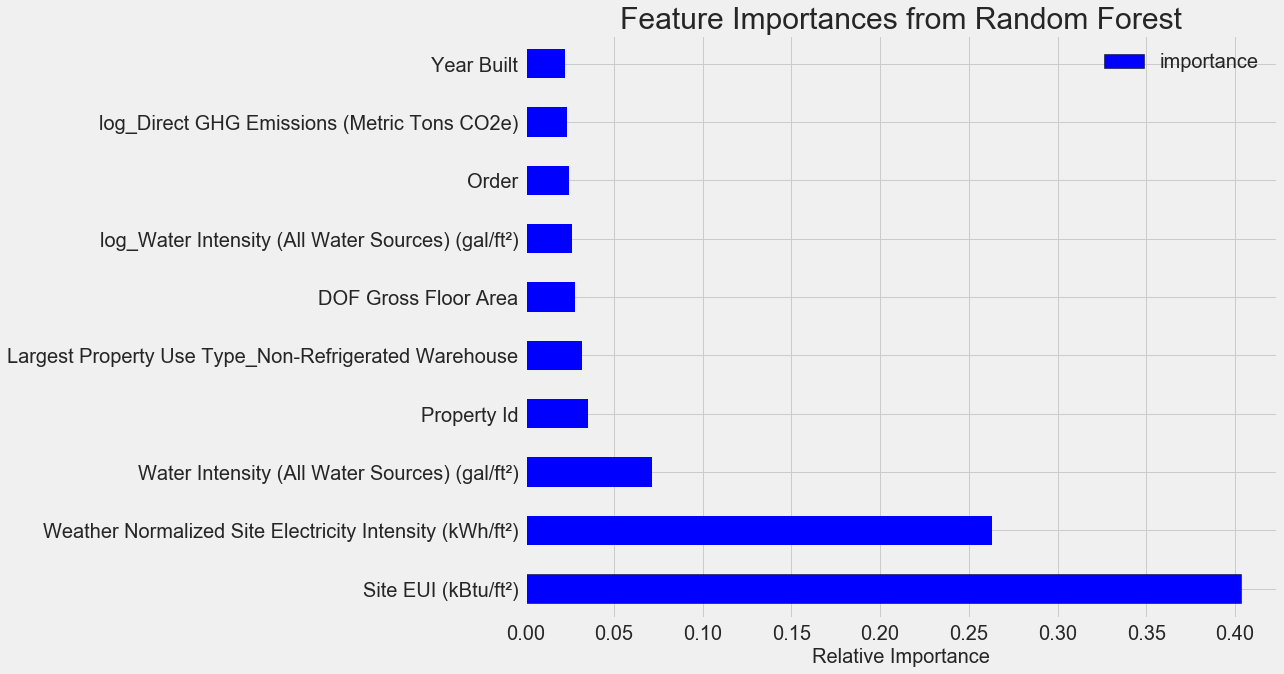

In [8]:
figsize(12, 10)
plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30);

### 可以基于重要性来进行特征选择

In [9]:
# Extract the names of the most important features
most_important_features = feature_results['feature'][:10]

# Find the index that corresponds to each feature name
indices = [list(train_features.columns).index(x) for x in most_important_features]

# Keep only the most important features
X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (6622, 10)
Most important testing  features shape:  (2839, 10)


In [10]:
lr = LinearRegression()

# Fit on full set of features
lr.fit(X, y)
lr_full_pred = lr.predict(X_test)

# Fit on reduced set of features
lr.fit(X_reduced, y)
lr_reduced_pred = lr.predict(X_test_reduced)

# Display results
print('Linear Regression Full Results: MAE =    %0.4f.' % mae(y_test, lr_full_pred))
print('Linear Regression Reduced Results: MAE = %0.4f.' % mae(y_test, lr_reduced_pred))

Linear Regression Full Results: MAE =    13.4651.
Linear Regression Reduced Results: MAE = 15.1007.


不要光靠想，试验结果发现效果还不如原来呢


In [11]:
# Create the model with the same hyperparamters
model_reduced = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

# Fit and test on the reduced set of features
model_reduced.fit(X_reduced, y)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('Gradient Boosted Reduced Results: MAE = %0.4f' % mae(y_test, model_reduced_pred))

Gradient Boosted Reduced Results: MAE = 10.8594


在GBDT中出现了同样的问题，所以我不选择去掉部分小价值特征。

### Locally Interpretable Model-agnostic Explanations

地址：[LIME to explain individual predictions](https://github.com/marcotcr/lime)

分别选择一个预测最好的和预测最差的来分别解释

In [12]:
# Find the residuals
residuals = abs(model_reduced_pred - y_test)
    
# Exact the worst and best prediction
wrong = X_test_reduced[np.argmax(residuals), :]
right = X_test_reduced[np.argmin(residuals), :]

In [13]:
# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_reduced, 
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = list(most_important_features))

Prediction: 12.8615
Actual Value: 100.0000


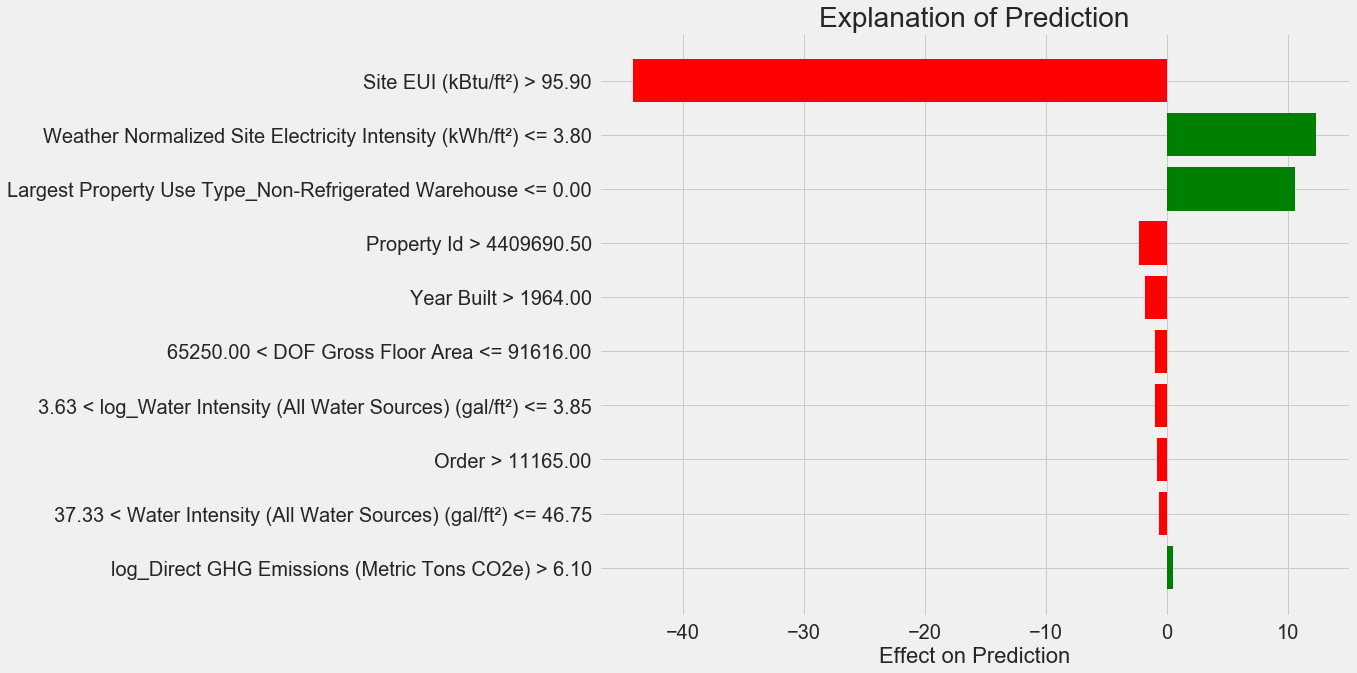

In [14]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(wrong.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmax(residuals)])

# Explanation for wrong prediction
wrong_exp = explainer.explain_instance(data_row = wrong, 
                                       predict_fn = model_reduced.predict)

# Plot the prediction explaination
wrong_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [15]:
wrong_exp.show_in_notebook(show_predicted_value=False)

预测值：12.86 实际值：100。这里面差距实在太大了，会不会存在什么问题呢？

上图展示了各个特征对结果的贡献程度，其中Site EUI使得结果值大大下降，由于该值本身大于95.50了，正常情况下是能源利用率较低了，但是这里反而标签的得分很高，所以有理由认为，该数据点标签值存在问题。另一个指标Weather Normalized Site Electricity低于3.80，看起来消耗不对所以对得分产生了促进作用，这是没问题的。

再来看看完全预测正确的例子

Prediction: 100.0000
Actual Value: 100.0000


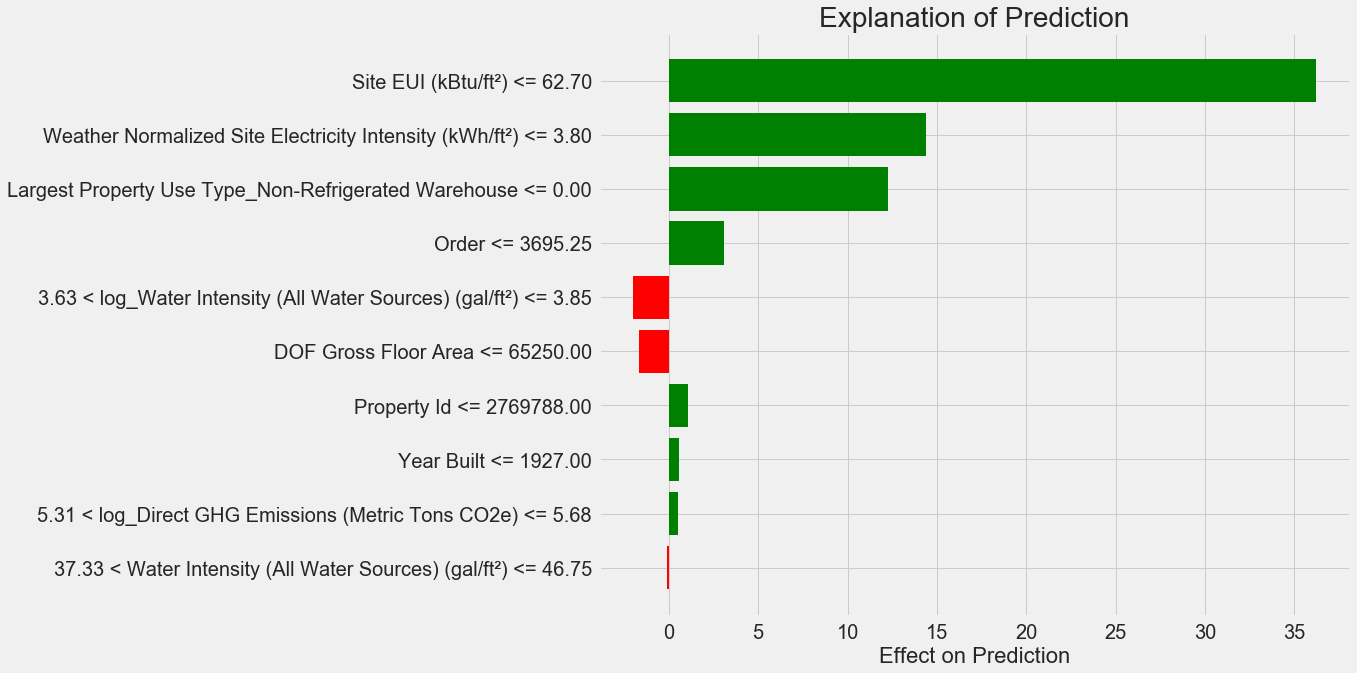

In [16]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(right.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmin(residuals)])

# Explanation for wrong prediction
right_exp = explainer.explain_instance(right, model_reduced.predict, num_features=10)
right_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [17]:
right_exp.show_in_notebook(show_predicted_value=False)

### 单颗树模型观察

In [18]:
# Extract a single tree
single_tree = model_reduced.estimators_[105][0]

tree.export_graphviz(single_tree, out_file = 'images/tree.dot',
                     rounded = True, 
                     feature_names = most_important_features,
                     filled = True)

single_tree

DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=6, min_samples_split=6,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x000001E133477438>,
           splitter='best')

In [19]:
# Convert to a png from the command line
# This requires the graphviz visualization library (https://www.graphviz.org/)


# !dot -Tpng images/tree.dot -o images/tree.png

![image](images/tree.png)

太密集了，限制下深度

In [20]:
tree.export_graphviz(single_tree, out_file = 'images/tree_small.dot',
                     rounded = True, feature_names = most_important_features,
                     filled = True, max_depth = 3)

![image](images/tree_small.png)